In [13]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, ZeroPadding2D, \
    Dropout, Conv2DTranspose, Cropping2D, Add, UpSampling2D, BatchNormalization
from keras.layers.merge import concatenate
from glob import glob
import sys
sys.path.insert(1, '../src')
sys.path.insert(1, '../image_segmentation_keras')
from keras_segmentation.models.model_utils import get_segmentation_model

from crfrnn_model import get_crfrnn_model_def
from crfrnn_layer import CrfRnnLayer
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope
i=0
if i==0:
    input_height = 256
    input_width = 256
    n_classes = 3
    channels = 3
    
    img_input = Input(shape=(input_height,input_width, channels))

    conv0 = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
#     conv0 = Dropout(0.2)(conv0)
    conv0 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv0)
    bn0 = BatchNormalization()(conv0)
    pool0 = MaxPooling2D((2, 2))(bn0)
    
    conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool0)
#     conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(bn1)

    conv2 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv2)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(bn2)

    conv3 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv3)
    bn3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(bn3)
    
    conv4 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv4)
    print("conv4",conv4.shape)
    print('conv3',conv3.shape)

    up_= Conv2DTranspose(512,(2,2),strides=2,padding='same')(conv4)
    print('up_',up_.shape)
    up0 = concatenate([up_, conv3], axis=3)
    print(up0.shape)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(up0)
#     conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    bn4 = BatchNormalization()(conv5)
    
    up_2= Conv2DTranspose(256,(2,2),strides=2,padding='same')(bn4)
    up1 = concatenate([up_2, conv2], axis=-1)
    print(up1.shape)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
#     conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    bn5 = BatchNormalization()(conv6)
    
    up_3= Conv2DTranspose(128,(2,2),strides=2,padding='same')(bn5)
    up2 = concatenate([up_3, conv1], axis=3)
    print(up2.shape)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
#     conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    bn6 = BatchNormalization()(conv7)
    
    up_4= Conv2DTranspose(64,(2,2),strides=2,padding='same')(bn6)
    up3 = concatenate([up_4, conv0], axis=3)
    print(up3.shape)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
#     conv8 = Dropout(0.2)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    bn7 = BatchNormalization()(conv8)
    print(conv8.shape)
    out = Conv2D( n_classes, (1, 1), activation='relu', padding='same')(bn7)   
    crf_output = CrfRnnLayer(image_dims=(input_height, input_width),
                         num_classes=n_classes,
                         theta_alpha=160.,
                         theta_beta=3.,
                         theta_gamma=3.,
                         num_iterations=10,
                         name='crfrnn')([out, img_input])
    model = get_segmentation_model(img_input, crf_output)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1
conv4 (None, 16, 16, 1024)
conv3 (None, 32, 32, 512)
up_ (None, None, None, 512)
(None, 32, 32, 1024)
(None, 64, 64, 512)
(None, 128, 128, 256)
(None, 256, 256, 128)
(None, 256, 256, 64)


In [2]:
model.train(
    train_images =  "/Users/mavaylon/Research/Data1/train/img/",
    train_annotations = "/Users/mavaylon/Research/Data1/train/ann/",
    epochs=20,
    steps_per_epoch=len(glob("/Users/mavaylon/Research/Data1/train/img/*")),
    batch_size=1,
    validate=True,
    val_images="/Users/mavaylon/Research/Data1/test/img/",
    val_annotations="/Users/mavaylon/Research/Data1/test/ann/",
    val_batch_size=1,
    val_steps_per_epoch=len(glob("/Users/mavaylon/Research/Data1/test/img/*"))
)

Verifying training dataset


  2%|▏         | 30/1478 [00:00<00:04, 292.18it/s]

Dataset verified! 
Verifying validation dataset


100%|██████████| 1478/1478 [00:04<00:00, 305.64it/s]


Dataset verified! 
correct
Epoch 1/20
5912/5912 [==============================] - 17398s 3s/step - loss: 0.6341 - accuracy: 0.7567 - val_loss: 0.4829 - val_accuracy: 0.7899

Epoch 00001: val_accuracy improved from -inf to 0.78994, saving model to pet_class_crf.h5
Epoch 2/20
5912/5912 [==============================] - 17730s 3s/step - loss: 0.5380 - accuracy: 0.8003 - val_loss: 0.4259 - val_accuracy: 0.8136

Epoch 00002: val_accuracy improved from 0.78994 to 0.81358, saving model to pet_class_crf.h5
Epoch 3/20
5912/5912 [==============================] - 17379s 3s/step - loss: 0.4794 - accuracy: 0.8247 - val_loss: 0.3971 - val_accuracy: 0.8322

Epoch 00003: val_accuracy improved from 0.81358 to 0.83221, saving model to pet_class_crf.h5
Epoch 4/20
5912/5912 [==============================] - 17397s 3s/step - loss: 0.4509 - accuracy: 0.8364 - val_loss: 0.4502 - val_accuracy: 0.8010

Epoch 00004: val_accuracy did not improve from 0.83221
Epoch 5/20
5912/5912 [============================

In [2]:
model.load_weights('/Users/mavaylon/Research/pet_weights/unet_petcrf/unet__shuffled_pet_class_crf_bn_after_bothconv.h5')

In [3]:
import cv2
import matplotlib.pyplot as plt

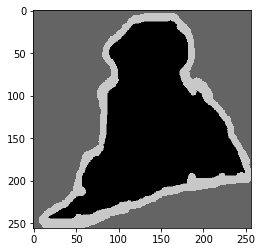

In [9]:
ann=cv2.imread('/Users/mavaylon/Research/Data1/test/ann/307great_pyrenees_35.png')
img=cv2.imread('/Users/mavaylon/Research/Data1/test/img/307great_pyrenees_35.png')
plt.imshow(ann*100)

In [8]:
import glob

img_names = ['/Users/mavaylon/Research/Data1/test/img/307great_pyrenees_35.png']

for name in img_names:
    out_name = "/Users/mavaylon/Research/Results/Pet_Results/UNET/CRF/Predictions/" + name.split('/')[-1]
    print(out_name)
    out = model.predict_segmentation(inp=name, out_fname=out_name)

/Users/mavaylon/Research/Results/Pet_Results/UNET/CRF/Predictions/307great_pyrenees_35.png


In [5]:
img_names = sorted(glob.glob("/Users/mavaylon/Downloads/Equalized/*.png"))
img_names

['/Users/mavaylon/Downloads/Equalized/image000.png',
 '/Users/mavaylon/Downloads/Equalized/image001.png',
 '/Users/mavaylon/Downloads/Equalized/image002.png',
 '/Users/mavaylon/Downloads/Equalized/image003.png',
 '/Users/mavaylon/Downloads/Equalized/image004.png',
 '/Users/mavaylon/Downloads/Equalized/image005.png',
 '/Users/mavaylon/Downloads/Equalized/image006.png',
 '/Users/mavaylon/Downloads/Equalized/image007.png',
 '/Users/mavaylon/Downloads/Equalized/image008.png',
 '/Users/mavaylon/Downloads/Equalized/image009.png',
 '/Users/mavaylon/Downloads/Equalized/image010.png',
 '/Users/mavaylon/Downloads/Equalized/image011.png',
 '/Users/mavaylon/Downloads/Equalized/image012.png',
 '/Users/mavaylon/Downloads/Equalized/image013.png',
 '/Users/mavaylon/Downloads/Equalized/image014.png',
 '/Users/mavaylon/Downloads/Equalized/image015.png',
 '/Users/mavaylon/Downloads/Equalized/image016.png',
 '/Users/mavaylon/Downloads/Equalized/image017.png',
 '/Users/mavaylon/Downloads/Equalized/image018